
# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.45KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

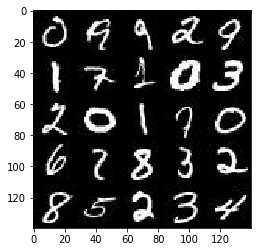

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

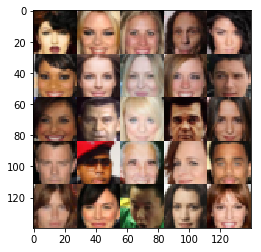

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    x_inputs = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z_inputs = tf.placeholder(tf.float32, [None, z_dim])
    learn_rate = tf.placeholder(tf.float32)

    return (x_inputs, z_inputs, learn_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # images: 28x28xdepth
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        x1 = tf.maximum(alpha*x1, x1)
        # x1: 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        # x2: 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        
        # x3: 4x4x256
        
        flat = tf.reshape(x3, [-1, 4*4*256])
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, [-1,4,4,512])
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # x1: 4x4x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # x2: 8x8x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        # x3: 16x16x128
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='SAME')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha*x4, x4)
        # x4: 32x32x64
        
        logits = tf.layers.conv2d(x4, out_channel_dim, 5, strides=1, padding='VALID')
        
    return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_out = generator(input_z, out_channel_dim)
    
    d_out_fake, d_logits_fake = discriminator(g_out)
    d_out_real, d_logits_real = discriminator(input_real, reuse=True)
    
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_logits_fake)))
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_logits_real)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_logits_fake)))
    d_loss = d_fake_loss + d_real_loss
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    n_color_channels = 3 if data_image_mode == 'RGB' else 1
    
    x_inputs, z_inputs, learn_rate = model_inputs(28, 28, n_color_channels, z_dim)
    d_loss, g_loss = model_loss(x_inputs, z_inputs, n_color_channels)
    d_optimizer, g_optimizer = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_i = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_i += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                sess.run(d_optimizer, feed_dict={x_inputs:batch_images, z_inputs:batch_z, learn_rate:learning_rate})
                sess.run(g_optimizer, feed_dict={x_inputs:batch_images, z_inputs:batch_z, learn_rate:learning_rate})
                print('batch: ', batch_i)
                if batch_i % 100 == 0:
                    show_generator_output(sess, 9, z_inputs, n_color_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

batch:  1
batch:  2
batch:  3
batch:  4
batch:  5
batch:  6
batch:  7
batch:  8
batch:  9
batch:  10
batch:  11
batch:  12
batch:  13
batch:  14
batch:  15
batch:  16
batch:  17
batch:  18
batch:  19
batch:  20
batch:  21
batch:  22
batch:  23
batch:  24
batch:  25
batch:  26
batch:  27
batch:  28
batch:  29
batch:  30
batch:  31
batch:  32
batch:  33
batch:  34
batch:  35
batch:  36
batch:  37
batch:  38
batch:  39
batch:  40
batch:  41
batch:  42
batch:  43
batch:  44
batch:  45
batch:  46
batch:  47
batch:  48
batch:  49
batch:  50
batch:  51
batch:  52
batch:  53
batch:  54
batch:  55
batch:  56
batch:  57
batch:  58
batch:  59
batch:  60
batch:  61
batch:  62
batch:  63
batch:  64
batch:  65
batch:  66
batch:  67
batch:  68
batch:  69
batch:  70
batch:  71
batch:  72
batch:  73
batch:  74
batch:  75
batch:  76
batch:  77
batch:  78
batch:  79
batch:  80
batch:  81
batch:  82
batch:  83
batch:  84
batch:  85
batch:  86
batch:  87
batch:  88
batch:  89
batch:  90
batch:  91
batch:  

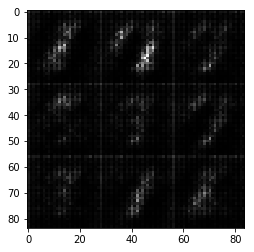

batch:  101
batch:  102
batch:  103
batch:  104
batch:  105
batch:  106
batch:  107
batch:  108
batch:  109
batch:  110
batch:  111
batch:  112
batch:  113
batch:  114
batch:  115
batch:  116
batch:  117
batch:  118
batch:  119
batch:  120
batch:  121
batch:  122
batch:  123
batch:  124
batch:  125
batch:  126
batch:  127
batch:  128
batch:  129
batch:  130
batch:  131
batch:  132
batch:  133
batch:  134
batch:  135
batch:  136
batch:  137
batch:  138
batch:  139
batch:  140
batch:  141
batch:  142
batch:  143
batch:  144
batch:  145
batch:  146
batch:  147
batch:  148
batch:  149
batch:  150
batch:  151
batch:  152
batch:  153
batch:  154
batch:  155
batch:  156
batch:  157
batch:  158
batch:  159
batch:  160
batch:  161
batch:  162
batch:  163
batch:  164
batch:  165
batch:  166
batch:  167
batch:  168
batch:  169
batch:  170
batch:  171
batch:  172
batch:  173
batch:  174
batch:  175
batch:  176
batch:  177
batch:  178
batch:  179
batch:  180
batch:  181
batch:  182
batch:  183
batc

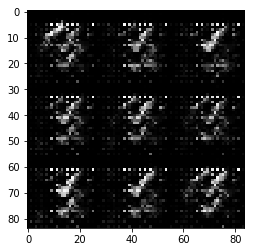

batch:  201
batch:  202
batch:  203
batch:  204
batch:  205
batch:  206
batch:  207
batch:  208
batch:  209
batch:  210
batch:  211
batch:  212
batch:  213
batch:  214
batch:  215
batch:  216
batch:  217
batch:  218
batch:  219
batch:  220
batch:  221
batch:  222
batch:  223
batch:  224
batch:  225
batch:  226
batch:  227
batch:  228
batch:  229
batch:  230
batch:  231
batch:  232
batch:  233
batch:  234
batch:  235
batch:  236
batch:  237
batch:  238
batch:  239
batch:  240
batch:  241
batch:  242
batch:  243
batch:  244
batch:  245
batch:  246
batch:  247
batch:  248
batch:  249
batch:  250
batch:  251
batch:  252
batch:  253
batch:  254
batch:  255
batch:  256
batch:  257
batch:  258
batch:  259
batch:  260
batch:  261
batch:  262
batch:  263
batch:  264
batch:  265
batch:  266
batch:  267
batch:  268
batch:  269
batch:  270
batch:  271
batch:  272
batch:  273
batch:  274
batch:  275
batch:  276
batch:  277
batch:  278
batch:  279
batch:  280
batch:  281
batch:  282
batch:  283
batc

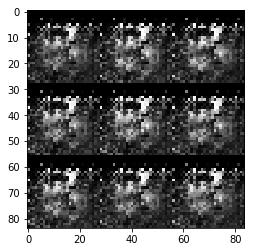

batch:  301
batch:  302
batch:  303
batch:  304
batch:  305
batch:  306
batch:  307
batch:  308
batch:  309
batch:  310
batch:  311
batch:  312
batch:  313
batch:  314
batch:  315
batch:  316
batch:  317
batch:  318
batch:  319
batch:  320
batch:  321
batch:  322
batch:  323
batch:  324
batch:  325
batch:  326
batch:  327
batch:  328
batch:  329
batch:  330
batch:  331
batch:  332
batch:  333
batch:  334
batch:  335
batch:  336
batch:  337
batch:  338
batch:  339
batch:  340
batch:  341
batch:  342
batch:  343
batch:  344
batch:  345
batch:  346
batch:  347
batch:  348
batch:  349
batch:  350
batch:  351
batch:  352
batch:  353
batch:  354
batch:  355
batch:  356
batch:  357
batch:  358
batch:  359
batch:  360
batch:  361
batch:  362
batch:  363
batch:  364
batch:  365
batch:  366
batch:  367
batch:  368
batch:  369
batch:  370
batch:  371
batch:  372
batch:  373
batch:  374
batch:  375
batch:  376
batch:  377
batch:  378
batch:  379
batch:  380
batch:  381
batch:  382
batch:  383
batc

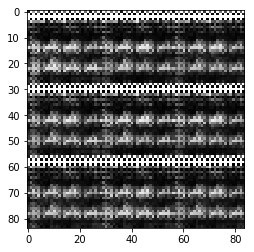

batch:  401
batch:  402
batch:  403
batch:  404
batch:  405
batch:  406
batch:  407
batch:  408
batch:  409
batch:  410
batch:  411
batch:  412
batch:  413
batch:  414
batch:  415
batch:  416
batch:  417
batch:  418
batch:  419
batch:  420
batch:  421
batch:  422
batch:  423
batch:  424
batch:  425
batch:  426
batch:  427
batch:  428
batch:  429
batch:  430
batch:  431
batch:  432
batch:  433
batch:  434
batch:  435
batch:  436
batch:  437
batch:  438
batch:  439
batch:  440
batch:  441
batch:  442
batch:  443
batch:  444
batch:  445
batch:  446
batch:  447
batch:  448
batch:  449
batch:  450
batch:  451
batch:  452
batch:  453
batch:  454
batch:  455
batch:  456
batch:  457
batch:  458
batch:  459
batch:  460
batch:  461
batch:  462
batch:  463
batch:  464
batch:  465
batch:  466
batch:  467
batch:  468
batch:  1
batch:  2
batch:  3
batch:  4
batch:  5
batch:  6
batch:  7
batch:  8
batch:  9
batch:  10
batch:  11
batch:  12
batch:  13
batch:  14
batch:  15
batch:  16
batch:  17
batch:

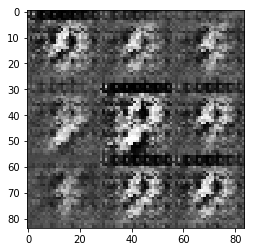

batch:  101
batch:  102
batch:  103
batch:  104
batch:  105
batch:  106
batch:  107
batch:  108
batch:  109
batch:  110
batch:  111
batch:  112
batch:  113
batch:  114
batch:  115
batch:  116
batch:  117
batch:  118
batch:  119
batch:  120
batch:  121
batch:  122
batch:  123
batch:  124
batch:  125
batch:  126
batch:  127
batch:  128
batch:  129
batch:  130
batch:  131
batch:  132
batch:  133
batch:  134
batch:  135
batch:  136
batch:  137
batch:  138
batch:  139
batch:  140
batch:  141
batch:  142
batch:  143
batch:  144
batch:  145
batch:  146
batch:  147
batch:  148
batch:  149
batch:  150
batch:  151
batch:  152
batch:  153
batch:  154
batch:  155
batch:  156
batch:  157
batch:  158
batch:  159
batch:  160
batch:  161
batch:  162
batch:  163
batch:  164
batch:  165
batch:  166
batch:  167
batch:  168
batch:  169
batch:  170
batch:  171
batch:  172
batch:  173
batch:  174
batch:  175
batch:  176
batch:  177
batch:  178
batch:  179
batch:  180
batch:  181
batch:  182
batch:  183
batc

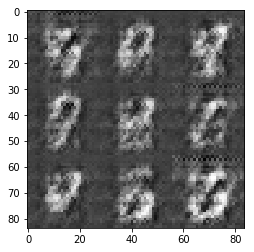

batch:  201
batch:  202
batch:  203
batch:  204
batch:  205
batch:  206
batch:  207
batch:  208
batch:  209
batch:  210
batch:  211
batch:  212
batch:  213
batch:  214
batch:  215
batch:  216
batch:  217
batch:  218
batch:  219
batch:  220
batch:  221
batch:  222
batch:  223
batch:  224
batch:  225
batch:  226
batch:  227
batch:  228
batch:  229
batch:  230
batch:  231
batch:  232
batch:  233
batch:  234
batch:  235
batch:  236
batch:  237
batch:  238
batch:  239
batch:  240
batch:  241
batch:  242
batch:  243
batch:  244
batch:  245
batch:  246
batch:  247
batch:  248
batch:  249
batch:  250
batch:  251
batch:  252
batch:  253
batch:  254
batch:  255
batch:  256
batch:  257
batch:  258
batch:  259
batch:  260
batch:  261
batch:  262
batch:  263
batch:  264
batch:  265
batch:  266
batch:  267
batch:  268
batch:  269
batch:  270
batch:  271
batch:  272
batch:  273
batch:  274
batch:  275
batch:  276
batch:  277
batch:  278
batch:  279
batch:  280
batch:  281
batch:  282
batch:  283
batc

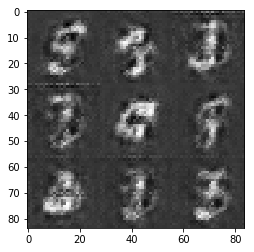

batch:  301
batch:  302
batch:  303
batch:  304
batch:  305
batch:  306
batch:  307
batch:  308
batch:  309
batch:  310
batch:  311
batch:  312
batch:  313
batch:  314
batch:  315
batch:  316
batch:  317
batch:  318
batch:  319
batch:  320
batch:  321
batch:  322
batch:  323
batch:  324
batch:  325
batch:  326
batch:  327
batch:  328
batch:  329
batch:  330
batch:  331
batch:  332
batch:  333
batch:  334
batch:  335
batch:  336
batch:  337
batch:  338
batch:  339
batch:  340
batch:  341
batch:  342
batch:  343
batch:  344
batch:  345
batch:  346
batch:  347
batch:  348
batch:  349
batch:  350
batch:  351
batch:  352
batch:  353
batch:  354
batch:  355
batch:  356
batch:  357
batch:  358
batch:  359
batch:  360
batch:  361
batch:  362
batch:  363
batch:  364
batch:  365
batch:  366
batch:  367
batch:  368
batch:  369
batch:  370
batch:  371
batch:  372
batch:  373
batch:  374
batch:  375
batch:  376
batch:  377
batch:  378
batch:  379
batch:  380
batch:  381
batch:  382
batch:  383
batc

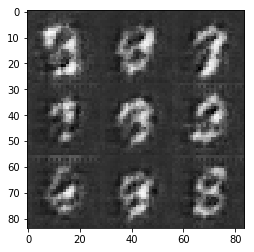

batch:  401
batch:  402
batch:  403
batch:  404
batch:  405
batch:  406
batch:  407
batch:  408
batch:  409
batch:  410
batch:  411
batch:  412
batch:  413
batch:  414
batch:  415
batch:  416
batch:  417
batch:  418
batch:  419
batch:  420
batch:  421
batch:  422
batch:  423
batch:  424
batch:  425
batch:  426
batch:  427
batch:  428
batch:  429
batch:  430
batch:  431
batch:  432
batch:  433
batch:  434
batch:  435
batch:  436
batch:  437
batch:  438
batch:  439
batch:  440
batch:  441
batch:  442
batch:  443
batch:  444
batch:  445
batch:  446
batch:  447
batch:  448
batch:  449
batch:  450
batch:  451
batch:  452
batch:  453
batch:  454
batch:  455
batch:  456
batch:  457
batch:  458
batch:  459
batch:  460
batch:  461
batch:  462
batch:  463
batch:  464
batch:  465
batch:  466
batch:  467
batch:  468
batch:  1
batch:  2
batch:  3
batch:  4
batch:  5
batch:  6
batch:  7
batch:  8
batch:  9
batch:  10
batch:  11
batch:  12
batch:  13
batch:  14
batch:  15
batch:  16
batch:  17
batch:

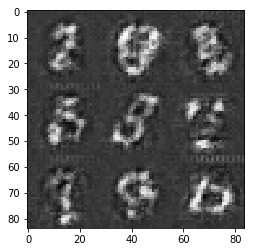

batch:  101
batch:  102
batch:  103
batch:  104
batch:  105
batch:  106
batch:  107
batch:  108
batch:  109
batch:  110
batch:  111
batch:  112
batch:  113
batch:  114
batch:  115
batch:  116
batch:  117
batch:  118
batch:  119
batch:  120
batch:  121
batch:  122
batch:  123
batch:  124
batch:  125
batch:  126
batch:  127
batch:  128
batch:  129
batch:  130
batch:  131
batch:  132
batch:  133
batch:  134
batch:  135
batch:  136
batch:  137
batch:  138
batch:  139
batch:  140
batch:  141
batch:  142
batch:  143
batch:  144
batch:  145
batch:  146
batch:  147
batch:  148
batch:  149
batch:  150
batch:  151
batch:  152
batch:  153
batch:  154
batch:  155
batch:  156
batch:  157
batch:  158
batch:  159
batch:  160
batch:  161
batch:  162
batch:  163
batch:  164
batch:  165
batch:  166
batch:  167
batch:  168
batch:  169
batch:  170
batch:  171
batch:  172
batch:  173
batch:  174
batch:  175
batch:  176
batch:  177
batch:  178
batch:  179
batch:  180
batch:  181
batch:  182
batch:  183
batc

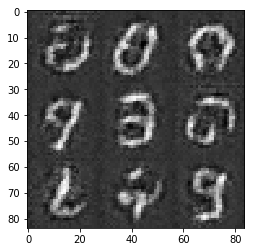

batch:  201
batch:  202
batch:  203
batch:  204
batch:  205
batch:  206
batch:  207
batch:  208
batch:  209
batch:  210
batch:  211
batch:  212
batch:  213
batch:  214
batch:  215
batch:  216
batch:  217
batch:  218
batch:  219
batch:  220
batch:  221
batch:  222
batch:  223
batch:  224
batch:  225
batch:  226
batch:  227
batch:  228
batch:  229
batch:  230
batch:  231
batch:  232
batch:  233
batch:  234
batch:  235
batch:  236
batch:  237
batch:  238
batch:  239
batch:  240
batch:  241
batch:  242
batch:  243
batch:  244
batch:  245
batch:  246
batch:  247
batch:  248
batch:  249
batch:  250
batch:  251
batch:  252
batch:  253
batch:  254
batch:  255
batch:  256
batch:  257
batch:  258
batch:  259
batch:  260
batch:  261
batch:  262
batch:  263
batch:  264
batch:  265
batch:  266
batch:  267
batch:  268
batch:  269
batch:  270
batch:  271
batch:  272
batch:  273
batch:  274
batch:  275
batch:  276
batch:  277
batch:  278
batch:  279
batch:  280
batch:  281
batch:  282
batch:  283
batc

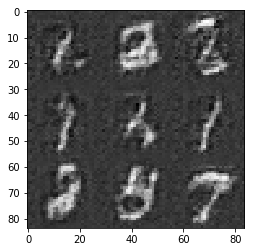

batch:  301
batch:  302
batch:  303
batch:  304
batch:  305
batch:  306
batch:  307
batch:  308
batch:  309
batch:  310
batch:  311
batch:  312
batch:  313
batch:  314
batch:  315
batch:  316
batch:  317
batch:  318
batch:  319
batch:  320
batch:  321
batch:  322
batch:  323
batch:  324
batch:  325
batch:  326
batch:  327
batch:  328
batch:  329
batch:  330
batch:  331
batch:  332
batch:  333
batch:  334
batch:  335
batch:  336
batch:  337
batch:  338
batch:  339
batch:  340
batch:  341
batch:  342
batch:  343
batch:  344
batch:  345
batch:  346
batch:  347
batch:  348
batch:  349
batch:  350
batch:  351
batch:  352
batch:  353
batch:  354
batch:  355
batch:  356
batch:  357
batch:  358
batch:  359
batch:  360
batch:  361
batch:  362
batch:  363
batch:  364
batch:  365
batch:  366
batch:  367
batch:  368
batch:  369
batch:  370
batch:  371
batch:  372
batch:  373
batch:  374
batch:  375
batch:  376
batch:  377
batch:  378
batch:  379
batch:  380
batch:  381
batch:  382
batch:  383
batc

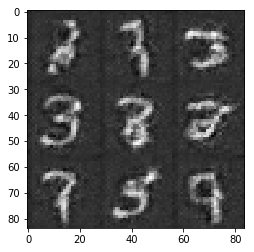

batch:  401
batch:  402
batch:  403
batch:  404
batch:  405
batch:  406
batch:  407
batch:  408
batch:  409
batch:  410
batch:  411
batch:  412
batch:  413
batch:  414
batch:  415
batch:  416
batch:  417
batch:  418
batch:  419
batch:  420
batch:  421
batch:  422
batch:  423
batch:  424
batch:  425
batch:  426
batch:  427
batch:  428
batch:  429
batch:  430
batch:  431
batch:  432
batch:  433
batch:  434
batch:  435
batch:  436
batch:  437
batch:  438
batch:  439
batch:  440
batch:  441
batch:  442
batch:  443
batch:  444
batch:  445
batch:  446
batch:  447
batch:  448
batch:  449
batch:  450
batch:  451
batch:  452
batch:  453
batch:  454
batch:  455
batch:  456
batch:  457
batch:  458
batch:  459
batch:  460
batch:  461
batch:  462
batch:  463
batch:  464
batch:  465
batch:  466
batch:  467
batch:  468


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

batch:  1
batch:  2
batch:  3
batch:  4
batch:  5
batch:  6
batch:  7
batch:  8
batch:  9
batch:  10
batch:  11
batch:  12
batch:  13
batch:  14
batch:  15
batch:  16
batch:  17
batch:  18
batch:  19
batch:  20
batch:  21
batch:  22
batch:  23
batch:  24
batch:  25
batch:  26
batch:  27
batch:  28
batch:  29
batch:  30
batch:  31
batch:  32
batch:  33
batch:  34
batch:  35
batch:  36
batch:  37
batch:  38
batch:  39
batch:  40
batch:  41
batch:  42
batch:  43
batch:  44
batch:  45
batch:  46
batch:  47
batch:  48
batch:  49
batch:  50
batch:  51
batch:  52
batch:  53
batch:  54
batch:  55
batch:  56
batch:  57
batch:  58
batch:  59
batch:  60
batch:  61
batch:  62
batch:  63
batch:  64
batch:  65
batch:  66
batch:  67
batch:  68
batch:  69
batch:  70
batch:  71
batch:  72
batch:  73
batch:  74
batch:  75
batch:  76
batch:  77
batch:  78
batch:  79
batch:  80
batch:  81
batch:  82
batch:  83
batch:  84
batch:  85
batch:  86
batch:  87
batch:  88
batch:  89
batch:  90
batch:  91
batch:  

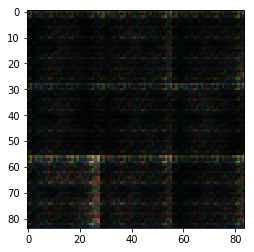

batch:  101
batch:  102
batch:  103
batch:  104
batch:  105
batch:  106
batch:  107
batch:  108
batch:  109
batch:  110
batch:  111
batch:  112
batch:  113
batch:  114
batch:  115
batch:  116
batch:  117
batch:  118
batch:  119
batch:  120
batch:  121
batch:  122
batch:  123
batch:  124
batch:  125
batch:  126
batch:  127
batch:  128
batch:  129
batch:  130
batch:  131
batch:  132
batch:  133
batch:  134
batch:  135
batch:  136
batch:  137
batch:  138
batch:  139
batch:  140
batch:  141
batch:  142
batch:  143
batch:  144
batch:  145
batch:  146
batch:  147
batch:  148
batch:  149
batch:  150
batch:  151
batch:  152
batch:  153
batch:  154
batch:  155
batch:  156
batch:  157
batch:  158
batch:  159
batch:  160
batch:  161
batch:  162
batch:  163
batch:  164
batch:  165
batch:  166
batch:  167
batch:  168
batch:  169
batch:  170
batch:  171
batch:  172
batch:  173
batch:  174
batch:  175
batch:  176
batch:  177
batch:  178
batch:  179
batch:  180
batch:  181
batch:  182
batch:  183
batc

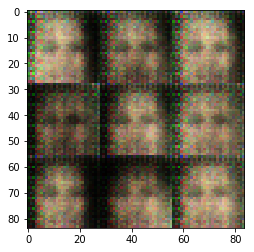

batch:  201
batch:  202
batch:  203
batch:  204
batch:  205
batch:  206
batch:  207
batch:  208
batch:  209
batch:  210
batch:  211
batch:  212
batch:  213
batch:  214
batch:  215
batch:  216
batch:  217
batch:  218
batch:  219
batch:  220
batch:  221
batch:  222
batch:  223
batch:  224
batch:  225
batch:  226
batch:  227
batch:  228
batch:  229
batch:  230
batch:  231
batch:  232
batch:  233
batch:  234
batch:  235
batch:  236
batch:  237
batch:  238
batch:  239
batch:  240
batch:  241
batch:  242
batch:  243
batch:  244
batch:  245
batch:  246
batch:  247
batch:  248
batch:  249
batch:  250
batch:  251
batch:  252
batch:  253
batch:  254
batch:  255
batch:  256
batch:  257
batch:  258
batch:  259
batch:  260
batch:  261
batch:  262
batch:  263
batch:  264
batch:  265
batch:  266
batch:  267
batch:  268
batch:  269
batch:  270
batch:  271
batch:  272
batch:  273
batch:  274
batch:  275
batch:  276
batch:  277
batch:  278
batch:  279
batch:  280
batch:  281
batch:  282
batch:  283
batc

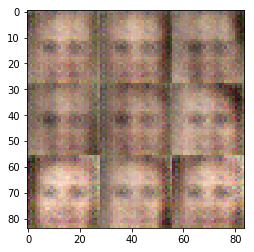

batch:  301
batch:  302
batch:  303
batch:  304
batch:  305
batch:  306
batch:  307
batch:  308
batch:  309
batch:  310
batch:  311
batch:  312
batch:  313
batch:  314
batch:  315
batch:  316
batch:  317
batch:  318
batch:  319
batch:  320
batch:  321
batch:  322
batch:  323
batch:  324
batch:  325
batch:  326
batch:  327
batch:  328
batch:  329
batch:  330
batch:  331
batch:  332
batch:  333
batch:  334
batch:  335
batch:  336
batch:  337
batch:  338
batch:  339
batch:  340
batch:  341
batch:  342
batch:  343
batch:  344
batch:  345
batch:  346
batch:  347
batch:  348
batch:  349
batch:  350
batch:  351
batch:  352
batch:  353
batch:  354
batch:  355
batch:  356
batch:  357
batch:  358
batch:  359
batch:  360
batch:  361
batch:  362
batch:  363
batch:  364
batch:  365
batch:  366
batch:  367
batch:  368
batch:  369
batch:  370
batch:  371
batch:  372
batch:  373
batch:  374
batch:  375
batch:  376
batch:  377
batch:  378
batch:  379
batch:  380
batch:  381
batch:  382
batch:  383
batc

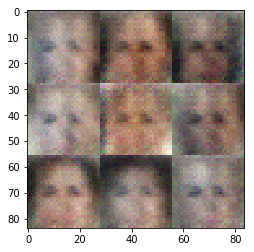

batch:  401
batch:  402
batch:  403
batch:  404
batch:  405
batch:  406
batch:  407
batch:  408
batch:  409
batch:  410
batch:  411
batch:  412
batch:  413
batch:  414
batch:  415
batch:  416
batch:  417
batch:  418
batch:  419
batch:  420
batch:  421
batch:  422
batch:  423
batch:  424
batch:  425
batch:  426
batch:  427
batch:  428
batch:  429
batch:  430
batch:  431
batch:  432
batch:  433
batch:  434
batch:  435
batch:  436
batch:  437
batch:  438
batch:  439
batch:  440
batch:  441
batch:  442
batch:  443
batch:  444
batch:  445
batch:  446
batch:  447
batch:  448
batch:  449
batch:  450
batch:  451
batch:  452
batch:  453
batch:  454
batch:  455
batch:  456
batch:  457
batch:  458
batch:  459
batch:  460
batch:  461
batch:  462
batch:  463
batch:  464
batch:  465
batch:  466
batch:  467
batch:  468
batch:  469
batch:  470
batch:  471
batch:  472
batch:  473
batch:  474
batch:  475
batch:  476
batch:  477
batch:  478
batch:  479
batch:  480
batch:  481
batch:  482
batch:  483
batc

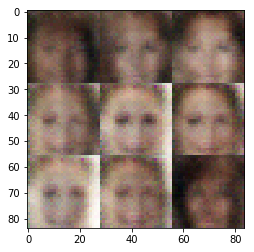

batch:  501
batch:  502
batch:  503
batch:  504
batch:  505
batch:  506
batch:  507
batch:  508
batch:  509
batch:  510
batch:  511
batch:  512
batch:  513
batch:  514
batch:  515
batch:  516
batch:  517
batch:  518
batch:  519
batch:  520
batch:  521
batch:  522
batch:  523
batch:  524
batch:  525
batch:  526
batch:  527
batch:  528
batch:  529
batch:  530
batch:  531
batch:  532
batch:  533
batch:  534
batch:  535
batch:  536
batch:  537
batch:  538
batch:  539
batch:  540
batch:  541
batch:  542
batch:  543
batch:  544
batch:  545
batch:  546
batch:  547
batch:  548
batch:  549
batch:  550
batch:  551
batch:  552
batch:  553
batch:  554
batch:  555
batch:  556
batch:  557
batch:  558
batch:  559
batch:  560
batch:  561
batch:  562
batch:  563
batch:  564
batch:  565
batch:  566
batch:  567
batch:  568
batch:  569
batch:  570
batch:  571
batch:  572
batch:  573
batch:  574
batch:  575
batch:  576
batch:  577
batch:  578
batch:  579
batch:  580
batch:  581
batch:  582
batch:  583
batc

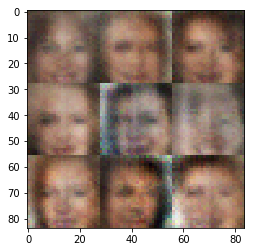

batch:  601
batch:  602
batch:  603
batch:  604
batch:  605
batch:  606
batch:  607
batch:  608
batch:  609
batch:  610
batch:  611
batch:  612
batch:  613
batch:  614
batch:  615
batch:  616
batch:  617
batch:  618
batch:  619
batch:  620
batch:  621
batch:  622
batch:  623
batch:  624
batch:  625
batch:  626
batch:  627
batch:  628
batch:  629
batch:  630
batch:  631
batch:  632
batch:  633
batch:  634
batch:  635
batch:  636
batch:  637
batch:  638
batch:  639
batch:  640
batch:  641
batch:  642
batch:  643
batch:  644
batch:  645
batch:  646
batch:  647
batch:  648
batch:  649
batch:  650
batch:  651
batch:  652
batch:  653
batch:  654
batch:  655
batch:  656
batch:  657
batch:  658
batch:  659
batch:  660
batch:  661
batch:  662
batch:  663
batch:  664
batch:  665
batch:  666
batch:  667
batch:  668
batch:  669
batch:  670
batch:  671
batch:  672
batch:  673
batch:  674
batch:  675
batch:  676
batch:  677
batch:  678
batch:  679
batch:  680
batch:  681
batch:  682
batch:  683
batc

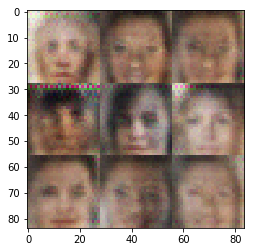

batch:  701
batch:  702
batch:  703
batch:  704
batch:  705
batch:  706
batch:  707
batch:  708
batch:  709
batch:  710
batch:  711
batch:  712
batch:  713
batch:  714
batch:  715
batch:  716
batch:  717
batch:  718
batch:  719
batch:  720
batch:  721
batch:  722
batch:  723
batch:  724
batch:  725
batch:  726
batch:  727
batch:  728
batch:  729
batch:  730
batch:  731
batch:  732
batch:  733
batch:  734
batch:  735
batch:  736
batch:  737
batch:  738
batch:  739
batch:  740
batch:  741
batch:  742
batch:  743
batch:  744
batch:  745
batch:  746
batch:  747
batch:  748
batch:  749
batch:  750
batch:  751
batch:  752
batch:  753
batch:  754
batch:  755
batch:  756
batch:  757
batch:  758
batch:  759
batch:  760
batch:  761
batch:  762
batch:  763
batch:  764
batch:  765
batch:  766
batch:  767
batch:  768
batch:  769
batch:  770
batch:  771
batch:  772
batch:  773
batch:  774
batch:  775
batch:  776
batch:  777
batch:  778
batch:  779
batch:  780
batch:  781
batch:  782
batch:  783
batc

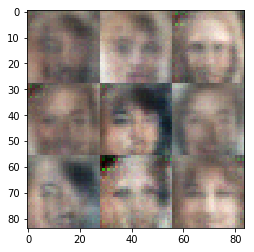

batch:  801
batch:  802
batch:  803
batch:  804
batch:  805
batch:  806
batch:  807
batch:  808
batch:  809
batch:  810
batch:  811
batch:  812
batch:  813
batch:  814
batch:  815
batch:  816
batch:  817
batch:  818
batch:  819
batch:  820
batch:  821
batch:  822
batch:  823
batch:  824
batch:  825
batch:  826
batch:  827
batch:  828
batch:  829
batch:  830
batch:  831
batch:  832
batch:  833
batch:  834
batch:  835
batch:  836
batch:  837
batch:  838
batch:  839
batch:  840
batch:  841
batch:  842
batch:  843
batch:  844
batch:  845
batch:  846
batch:  847
batch:  848
batch:  849
batch:  850
batch:  851
batch:  852
batch:  853
batch:  854
batch:  855
batch:  856
batch:  857
batch:  858
batch:  859
batch:  860
batch:  861
batch:  862
batch:  863
batch:  864
batch:  865
batch:  866
batch:  867
batch:  868
batch:  869
batch:  870
batch:  871
batch:  872
batch:  873
batch:  874
batch:  875
batch:  876
batch:  877
batch:  878
batch:  879
batch:  880
batch:  881
batch:  882
batch:  883
batc

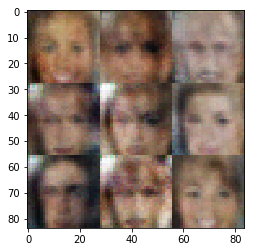

batch:  901
batch:  902
batch:  903
batch:  904
batch:  905
batch:  906
batch:  907
batch:  908
batch:  909
batch:  910
batch:  911
batch:  912
batch:  913
batch:  914
batch:  915
batch:  916
batch:  917
batch:  918
batch:  919
batch:  920
batch:  921
batch:  922
batch:  923
batch:  924
batch:  925
batch:  926
batch:  927
batch:  928
batch:  929
batch:  930
batch:  931
batch:  932
batch:  933
batch:  934
batch:  935
batch:  936
batch:  937
batch:  938
batch:  939
batch:  940
batch:  941
batch:  942
batch:  943
batch:  944
batch:  945
batch:  946
batch:  947
batch:  948
batch:  949
batch:  950
batch:  951
batch:  952
batch:  953
batch:  954
batch:  955
batch:  956
batch:  957
batch:  958
batch:  959
batch:  960
batch:  961
batch:  962
batch:  963
batch:  964
batch:  965
batch:  966
batch:  967
batch:  968
batch:  969
batch:  970
batch:  971
batch:  972
batch:  973
batch:  974
batch:  975
batch:  976
batch:  977
batch:  978
batch:  979
batch:  980
batch:  981
batch:  982
batch:  983
batc

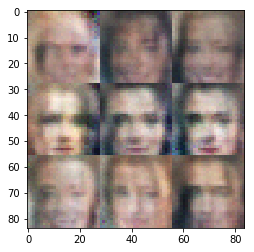

batch:  1001
batch:  1002
batch:  1003
batch:  1004
batch:  1005
batch:  1006
batch:  1007
batch:  1008
batch:  1009
batch:  1010
batch:  1011
batch:  1012
batch:  1013
batch:  1014
batch:  1015
batch:  1016
batch:  1017
batch:  1018
batch:  1019
batch:  1020
batch:  1021
batch:  1022
batch:  1023
batch:  1024
batch:  1025
batch:  1026
batch:  1027
batch:  1028
batch:  1029
batch:  1030
batch:  1031
batch:  1032
batch:  1033
batch:  1034
batch:  1035
batch:  1036
batch:  1037
batch:  1038
batch:  1039
batch:  1040
batch:  1041
batch:  1042
batch:  1043
batch:  1044
batch:  1045
batch:  1046
batch:  1047
batch:  1048
batch:  1049
batch:  1050
batch:  1051
batch:  1052
batch:  1053
batch:  1054
batch:  1055
batch:  1056
batch:  1057
batch:  1058
batch:  1059
batch:  1060
batch:  1061
batch:  1062
batch:  1063
batch:  1064
batch:  1065
batch:  1066
batch:  1067
batch:  1068
batch:  1069
batch:  1070
batch:  1071
batch:  1072
batch:  1073
batch:  1074
batch:  1075
batch:  1076
batch:  1077

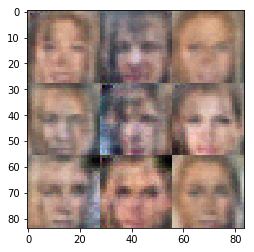

batch:  1101
batch:  1102
batch:  1103
batch:  1104
batch:  1105
batch:  1106
batch:  1107
batch:  1108
batch:  1109
batch:  1110
batch:  1111
batch:  1112
batch:  1113
batch:  1114
batch:  1115
batch:  1116
batch:  1117
batch:  1118
batch:  1119
batch:  1120
batch:  1121
batch:  1122
batch:  1123
batch:  1124
batch:  1125
batch:  1126
batch:  1127
batch:  1128
batch:  1129
batch:  1130
batch:  1131
batch:  1132
batch:  1133
batch:  1134
batch:  1135
batch:  1136
batch:  1137
batch:  1138
batch:  1139
batch:  1140
batch:  1141
batch:  1142
batch:  1143
batch:  1144
batch:  1145
batch:  1146
batch:  1147
batch:  1148
batch:  1149
batch:  1150
batch:  1151
batch:  1152
batch:  1153
batch:  1154
batch:  1155
batch:  1156
batch:  1157
batch:  1158
batch:  1159
batch:  1160
batch:  1161
batch:  1162
batch:  1163
batch:  1164
batch:  1165
batch:  1166
batch:  1167
batch:  1168
batch:  1169
batch:  1170
batch:  1171
batch:  1172
batch:  1173
batch:  1174
batch:  1175
batch:  1176
batch:  1177

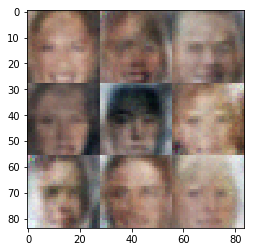

batch:  1201
batch:  1202
batch:  1203
batch:  1204
batch:  1205
batch:  1206
batch:  1207
batch:  1208
batch:  1209
batch:  1210
batch:  1211
batch:  1212
batch:  1213
batch:  1214
batch:  1215
batch:  1216
batch:  1217
batch:  1218
batch:  1219
batch:  1220
batch:  1221
batch:  1222
batch:  1223
batch:  1224
batch:  1225
batch:  1226
batch:  1227
batch:  1228
batch:  1229
batch:  1230
batch:  1231
batch:  1232
batch:  1233
batch:  1234
batch:  1235
batch:  1236
batch:  1237
batch:  1238
batch:  1239
batch:  1240
batch:  1241
batch:  1242
batch:  1243
batch:  1244
batch:  1245
batch:  1246
batch:  1247
batch:  1248
batch:  1249
batch:  1250
batch:  1251
batch:  1252
batch:  1253
batch:  1254
batch:  1255
batch:  1256
batch:  1257
batch:  1258
batch:  1259
batch:  1260
batch:  1261
batch:  1262
batch:  1263
batch:  1264
batch:  1265
batch:  1266
batch:  1267
batch:  1268
batch:  1269
batch:  1270
batch:  1271
batch:  1272
batch:  1273
batch:  1274
batch:  1275
batch:  1276
batch:  1277

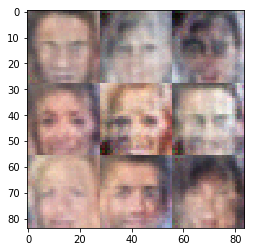

batch:  1301
batch:  1302
batch:  1303
batch:  1304
batch:  1305
batch:  1306
batch:  1307
batch:  1308
batch:  1309
batch:  1310
batch:  1311
batch:  1312
batch:  1313
batch:  1314
batch:  1315
batch:  1316
batch:  1317
batch:  1318
batch:  1319
batch:  1320
batch:  1321
batch:  1322
batch:  1323
batch:  1324
batch:  1325
batch:  1326
batch:  1327
batch:  1328
batch:  1329
batch:  1330
batch:  1331
batch:  1332
batch:  1333
batch:  1334
batch:  1335
batch:  1336
batch:  1337
batch:  1338
batch:  1339
batch:  1340
batch:  1341
batch:  1342
batch:  1343
batch:  1344
batch:  1345
batch:  1346
batch:  1347
batch:  1348
batch:  1349
batch:  1350
batch:  1351
batch:  1352
batch:  1353
batch:  1354
batch:  1355
batch:  1356
batch:  1357
batch:  1358
batch:  1359
batch:  1360
batch:  1361
batch:  1362
batch:  1363
batch:  1364
batch:  1365
batch:  1366
batch:  1367
batch:  1368
batch:  1369
batch:  1370
batch:  1371
batch:  1372
batch:  1373
batch:  1374
batch:  1375
batch:  1376
batch:  1377

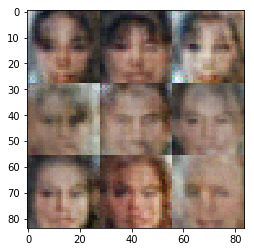

batch:  1401
batch:  1402
batch:  1403
batch:  1404
batch:  1405
batch:  1406
batch:  1407
batch:  1408
batch:  1409
batch:  1410
batch:  1411
batch:  1412
batch:  1413
batch:  1414
batch:  1415
batch:  1416
batch:  1417
batch:  1418
batch:  1419
batch:  1420
batch:  1421
batch:  1422
batch:  1423
batch:  1424
batch:  1425
batch:  1426
batch:  1427
batch:  1428
batch:  1429
batch:  1430
batch:  1431
batch:  1432
batch:  1433
batch:  1434
batch:  1435
batch:  1436
batch:  1437
batch:  1438
batch:  1439
batch:  1440
batch:  1441
batch:  1442
batch:  1443
batch:  1444
batch:  1445
batch:  1446
batch:  1447
batch:  1448
batch:  1449
batch:  1450
batch:  1451
batch:  1452
batch:  1453
batch:  1454
batch:  1455
batch:  1456
batch:  1457
batch:  1458
batch:  1459
batch:  1460
batch:  1461
batch:  1462
batch:  1463
batch:  1464
batch:  1465
batch:  1466
batch:  1467
batch:  1468
batch:  1469
batch:  1470
batch:  1471
batch:  1472
batch:  1473
batch:  1474
batch:  1475
batch:  1476
batch:  1477

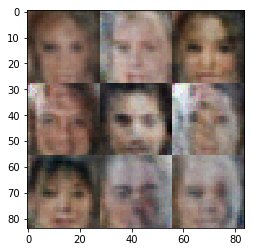

batch:  1501
batch:  1502
batch:  1503
batch:  1504
batch:  1505
batch:  1506
batch:  1507
batch:  1508
batch:  1509
batch:  1510
batch:  1511
batch:  1512
batch:  1513
batch:  1514
batch:  1515
batch:  1516
batch:  1517
batch:  1518
batch:  1519
batch:  1520
batch:  1521
batch:  1522
batch:  1523
batch:  1524
batch:  1525
batch:  1526
batch:  1527
batch:  1528
batch:  1529
batch:  1530
batch:  1531
batch:  1532
batch:  1533
batch:  1534
batch:  1535
batch:  1536
batch:  1537
batch:  1538
batch:  1539
batch:  1540
batch:  1541
batch:  1542
batch:  1543
batch:  1544
batch:  1545
batch:  1546
batch:  1547
batch:  1548
batch:  1549
batch:  1550
batch:  1551
batch:  1552
batch:  1553
batch:  1554
batch:  1555
batch:  1556
batch:  1557
batch:  1558
batch:  1559
batch:  1560
batch:  1561
batch:  1562
batch:  1563
batch:  1564
batch:  1565
batch:  1566
batch:  1567
batch:  1568
batch:  1569
batch:  1570
batch:  1571
batch:  1572
batch:  1573
batch:  1574
batch:  1575
batch:  1576
batch:  1577

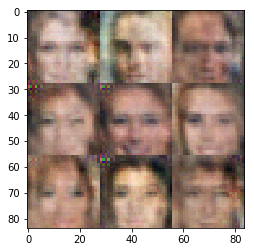

batch:  101
batch:  102
batch:  103
batch:  104
batch:  105
batch:  106
batch:  107
batch:  108
batch:  109
batch:  110
batch:  111
batch:  112
batch:  113
batch:  114
batch:  115
batch:  116
batch:  117
batch:  118
batch:  119
batch:  120
batch:  121
batch:  122
batch:  123
batch:  124
batch:  125
batch:  126
batch:  127
batch:  128
batch:  129
batch:  130
batch:  131
batch:  132
batch:  133
batch:  134
batch:  135
batch:  136
batch:  137
batch:  138
batch:  139
batch:  140
batch:  141
batch:  142
batch:  143
batch:  144
batch:  145
batch:  146
batch:  147
batch:  148
batch:  149
batch:  150
batch:  151
batch:  152
batch:  153
batch:  154
batch:  155
batch:  156
batch:  157
batch:  158
batch:  159
batch:  160
batch:  161
batch:  162
batch:  163
batch:  164
batch:  165
batch:  166
batch:  167
batch:  168
batch:  169
batch:  170
batch:  171
batch:  172
batch:  173
batch:  174
batch:  175
batch:  176
batch:  177
batch:  178
batch:  179
batch:  180
batch:  181
batch:  182
batch:  183
batc

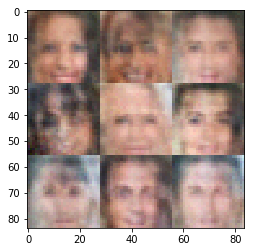

batch:  201
batch:  202
batch:  203
batch:  204
batch:  205
batch:  206
batch:  207
batch:  208
batch:  209
batch:  210
batch:  211
batch:  212
batch:  213
batch:  214
batch:  215
batch:  216
batch:  217
batch:  218
batch:  219
batch:  220
batch:  221
batch:  222
batch:  223
batch:  224
batch:  225
batch:  226
batch:  227
batch:  228
batch:  229
batch:  230
batch:  231
batch:  232
batch:  233
batch:  234
batch:  235
batch:  236
batch:  237
batch:  238
batch:  239
batch:  240
batch:  241
batch:  242
batch:  243
batch:  244
batch:  245
batch:  246
batch:  247
batch:  248
batch:  249
batch:  250
batch:  251
batch:  252
batch:  253
batch:  254
batch:  255
batch:  256
batch:  257
batch:  258
batch:  259
batch:  260
batch:  261
batch:  262
batch:  263
batch:  264
batch:  265
batch:  266
batch:  267
batch:  268
batch:  269
batch:  270
batch:  271
batch:  272
batch:  273
batch:  274
batch:  275
batch:  276
batch:  277
batch:  278
batch:  279
batch:  280
batch:  281
batch:  282
batch:  283
batc

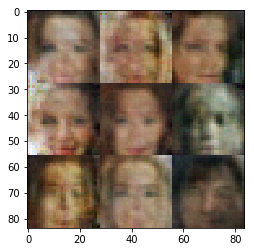

batch:  301
batch:  302
batch:  303
batch:  304
batch:  305
batch:  306
batch:  307
batch:  308
batch:  309
batch:  310
batch:  311
batch:  312
batch:  313
batch:  314
batch:  315
batch:  316
batch:  317
batch:  318
batch:  319
batch:  320
batch:  321
batch:  322
batch:  323
batch:  324
batch:  325
batch:  326
batch:  327
batch:  328
batch:  329
batch:  330
batch:  331
batch:  332
batch:  333
batch:  334
batch:  335
batch:  336
batch:  337
batch:  338
batch:  339
batch:  340
batch:  341
batch:  342
batch:  343
batch:  344
batch:  345
batch:  346
batch:  347
batch:  348
batch:  349
batch:  350
batch:  351
batch:  352
batch:  353
batch:  354
batch:  355
batch:  356
batch:  357
batch:  358
batch:  359
batch:  360
batch:  361
batch:  362
batch:  363
batch:  364
batch:  365
batch:  366
batch:  367
batch:  368
batch:  369
batch:  370
batch:  371
batch:  372
batch:  373
batch:  374
batch:  375
batch:  376
batch:  377
batch:  378
batch:  379
batch:  380
batch:  381
batch:  382
batch:  383
batc

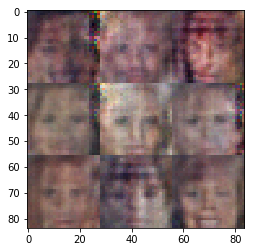

batch:  401
batch:  402
batch:  403
batch:  404
batch:  405
batch:  406
batch:  407
batch:  408
batch:  409
batch:  410
batch:  411


KeyboardInterrupt: 

In [16]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.